In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config( display='diagram')

In [103]:
# Use this cell to regroup all your imports

from scipy import stats

# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

# Load

❓ Load the train dataset in a DataFrame `data` and create your `X` and `y`. Inspect their shape

In [3]:
# You can use this direct download link if you don't want to create a Kaggle account
data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [82]:
X = data.drop(columns=['SalePrice', "Id"])
y = data["SalePrice"]
X.shape

(1460, 79)

# 🐣 BASELINE

## Initial feature overview

80 features is too much to deal with one-by-one for a first baseline pipeline! Let's treat them solely based on their `dtype`:

❓ How many numerical features vs. categorical features do we have? 

In [8]:
X.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

❓ Store the Series `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set. How many unique categories are there in total ?

In [15]:
feat_categorical_nunique = X.select_dtypes(include="object").nunique()
feat_categorical_nunique.sum()

252

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix `X_preproc` would become pretty big and spare, with almost 300 (highly correlated) features for only 1400 observations. Ideally, we should aim at feeding our model with 50-100 features max (📚 Read this [rule of thumb](https://datascience.stackexchange.com/a/11480/98300))

There are 2 main strategies to reduce the number of categorical features post-preprocessing:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model. This may require statistical analysis of feature importance 
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly!

❓ Plot the **histogram** of number of unique value per categorical feature. Do you see some quick wins?

<AxesSubplot:>

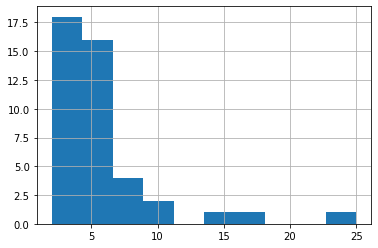

In [18]:
feat_categorical_nunique.hist()

💡 As a starter, what about simply removing all features that have **7 unique values or more**, and one-hot-encode every others? Let's keep ordinal encoding and statistical feature selection for the next iteration.

❓ Store features to OHE in a list `feat_categorical_small` below. How many features will be OHE?

In [36]:
feat_categorical_small = [c for c, v in feat_categorical_nunique.iteritems() 
                          if v < 7]

In [40]:
len(feat_categorical_small)

34

In [42]:
# feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique < 7].index)
# len(feat_categorical_small)

🧪 Test your code below (and clear the cell once it passed)

## Preprocessing pipeline - V1 minimal baseline

---
❓ Let's code the basic preprocessing pipeline described below. Save it under `preproc_baseline`.

For categorical features
- Simple-Impute with most frequent values
- One-Hot-Encode features that have less than 7 unique values to start with
- Drop all others features


As for numerical features
- Simple-Impute with strategy 'mean'
- Min-Max Scale 


<details>
    <summary>ℹ️ Pro tips</summary>

If you are confident, you can try sklearn's shorter syntax `make_pipeline` or `make_column_transformer` instead of the longer syntax `Pipeline` or `ColumnTransformer` if you want to avoid giving names manually to every steps.
</details>

In [53]:
# make a Column Transformer made of 2 pipelines (1 for OHE, 1 for numerical)

num_tr = make_pipeline(
    SimpleImputer(strategy='mean'),
    MinMaxScaler())

cat_tr = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore'))

preproc_baseline = make_column_transformer(
    (num_tr, make_column_selector(dtype_include=['int64', 'float64'])),
    (cat_tr, feat_categorical_small),
    remainder='drop')

preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f32bbcfcdf0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ign...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

In [54]:
# # We need a Column Transformer made of 2 pipelines (1 for OHE, 1 for numerical)

# preproc_numerical_baseline = make_pipeline(
#             SimpleImputer(), 
#             MinMaxScaler())

# preproc_categorical_baseline = make_pipeline(
#           SimpleImputer(strategy='most_frequent'),
#           OneHotEncoder(handle_unknown='ignore'))

# preproc_baseline = make_column_transformer(
#          (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
#          (preproc_categorical_baseline, feat_categorical_small),
#          remainder="drop")

# preproc_baseline

In [59]:
shape_preproc_baseline = pd.DataFrame(preproc_baseline.fit_transform(X)).shape
shape_preproc_baseline

(1460, 183)

❓ Look at the **shape** of your preprocessed dataframe.

🧪 Test your code below

## Model baseline

❓ Pipe a basic Ridge regressor to your `preproc_baseline` and store it to `pipe_baseline` variable.

In [61]:
pipe_baseline = make_pipeline(preproc_baseline,
                              Ridge())
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f32bbcfcdf0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencod...
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('ridge', Ridge())])

❓ Read the Kaggle [contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) 
- Which performance metric do you need? Is it readily available in sklearn?
- Create a scorer using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) and store it into a variable named `rmsle`
- Create also the negative score `rmsle_neg` which is best when _maximized_. This will come handy later as `GridSearchCV` requires a score to _maximize_

In [ ]:
# # OPTION 1: recode it all manually

# def root_mean_squared_log_error(y_true, y_pred):
#     t = np.array(y_true)
#     p = np.array(y_pred)
#     log_error = np.log(1+t) - np.log(1+p)
#     return ((log_error**2).mean())**0.5

# # This is our metric to minimize
# rmsle = make_scorer(root_mean_squared_log_error)

# # This is our score to maximize
# rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * root_mean_squared_log_error(y_true, y_pred))

In [248]:
# OPTION 2 - reuse sklearn "mean_squared_log_error"
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer

# This is the metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1* mean_squared_log_error(y_true, y_pred)**0.5)

# Equivalent formulation
rmsle_neg = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5, 
                        greater_is_better=False)

❓5-fold cross_validate your `pipe_baseline` using this metric to get a first glance at your baseline perf.    
Store your mean score as `score_baseline`

In [70]:
from sklearn.model_selection import cross_val_score

# Cross validate the final_pipe
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
score_baseline

0.16642907520861638

## Predict baseline

❓ Predict `y_pred_baseline` from the Kaggle `test.csv` dataset you stored in the `data` folder.

In [84]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")
X_test_ids = X_test['Id'] # keep ids
X_test = X_test.drop(columns=['Id'])

# Predict y_pred_baseline
pipe_baseline.fit(X, y)
y_pred_baseline = pipe_baseline.predict(X_test)
y_pred_baseline

array([113256.76959388, 136811.0145436 , 174901.68834287, ...,
       157216.07718185, 111472.49591662, 234985.99120322])

❓ Finally, store your CSV ready to be submitted as `submission_baseline.csv` in the `data` folder. Read carefully the Kaggle required format and test it below (you don't need to submit this baseline online for now).

In [89]:
result = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name='SalePrice')], axis=1)
result.head(3)

,Id,SalePrice
0,1461,113256.769594
1,1462,136811.014544
2,1463,174901.688343


In [90]:
result.to_csv("data/submission_baseline.csv", header=True, index=False)

🧪 Test your code

# 🏋️‍♀️ ITERATIONS 

🎉 🎉 Congratulation for having fully pipelined a basline model! You will see now how easier it is to iterate and improve performance 🚀

- Your goal is to improve your prediction and submit it by **16h30 max online**
- We suggested you some improvements below
- **Pick up your fights** and **incrementally** improve your pipeline as you see fit

**Models**

- Linear Models: fine-tune regularization ?
- **Tree-based ensembles (must try today)**: Probably the best suited for many categorical-features problems
- Stacking !
- ...

**Preprocessing** (once your first ensemble models works)

- Ordinal Encoding of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- Statistical Feature Selection to remove useless features (avoid overfitting and reduce train time)
- Predict log(SalePrice) instead?
- ...

## Preprocessing Iteration

### Ordinal Encoding

❓ Look at the following feature below. Couldn't it be encoded numerically in a wise manner?
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 Luckily, the `OrdinalEncoder` and its argument `categories`  allows us to do just that. Check it out below and make sure to understand how ths works

In [125]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good'] 
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ['good', 'new'],
        ['bad', 'oooops never seen this label before']
])

array([[ 0.,  0.],
       [ 2.,  2.],
       [ 0., -1.]])

---
❓ **Your turn**: split your categorical preprocessor into

- `preproc_ordinal` to ordinally encode **some features** of your choice (**do a quick iteration first**)
- `preproc_nominal` to one hot encode the other ones


<details>
    <summary>Hints</summary>

- You won't be able to avoid hard-coding names and ordered values of features! Be tidy!
- It's a good practice to sort alphabetically your features to avoid bad surprises
</details>

In [131]:
feat_ordinal_dict = {
    # considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
}

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown= "use_encoded_value",
    unknown_value= -1 # consider unknown values as worse than 'missing'
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    encoder_ordinal,
    MinMaxScaler()
)
preproc_ordinal

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

In [151]:
# Define numerical feature
feat_numerical = sorted(X.select_dtypes(include=['int64', "float64"]).columns)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

In [149]:
# Define norminal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_norminal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_norminal = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

In [152]:
# make a column transformer to pipe the 3 preprocs(feat_ordinal, feat_numerical and feat_nominal)

preproc = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=['int64', 'float64'])),
    (preproc_ordinal, feat_ordinal),
    (preproc_norminal, feat_norminal),
    remainder='drop')

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f328d26b940>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categor...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities'])])

In [153]:
preproc.fit_transform(X).shape

(1460, 216)

### Target engineering

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its log?
- Check-out historgram of your target `y`. Normally distributed variables should be easier to predict with linear models. 
- Create `y_log` and your new performance metrics
- Don't forget at the end to take the exponential of your predictions!

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

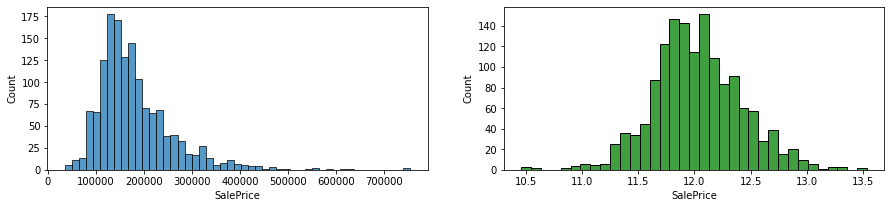

In [206]:
y_log = np.log(y)

plt.figure(figsize=(15,3))

plt.subplot(1,2,1)
sns.histplot(y)

plt.subplot(1,2,2)
sns.histplot(y_log, color='green')

In [204]:
from sklearn.metrics import mean_squared_error
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Create new scorer to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

### Statistical Feature Selection

Our goal is to remove the least interesting features, to limit overfitting and shorten training time.  
Choose one of the 3 options below

#### (option 1 - recommended) univariate feature selection based on relationship with target `y`

❓ We will use sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) tools directly in your pipeline.
- Add a `SelectPercentile` filter (coupled with `mutual_info_regression` for the statistical test to use) at the end of your `preproc` pipeline.
- This will filter-out features that, - taken individually - least explain your target!  

In [159]:
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=['int64', 'float64'])),
    (preproc_ordinal, feat_ordinal),
    (preproc_norminal, feat_norminal),
    remainder='drop')

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50 # keep only 50% of all features
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f328e8871f0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('o...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x7f328db46f70>))])

In [160]:
preproc.fit_transform(X, y).shape

(1460, 108)

#### (option 2) multivariate feature selection based their common relationship with target `y`

❓ We will use sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) tools directly in your pipeline.
- Add a `SequentialFeatureSelector` at the end of your `preproc` pipeline.
- This will recursively filter-out least important features according to `feature_permutation` importance!  
- Probably overkill for such small dataset!

In [171]:
# # TODO: Create a Solution
# from sklearn.feature_selection import SequentialFeatureSelector

# preproc_2 = make_pipeline(
#     SequentialFeatureSelector(preproc, scoring=rmsle)
# )

# preproc_2

#### (option 3) Filter based only on the properties of `X` ?

❓ Use Pearson's correlation combined with a heatmap...
- to check visually whether some **numerical** features almost entirely explain others. 
- Then, create a "filter" in your pipeline that removes any correlated below a certain threshold

<AxesSubplot:>

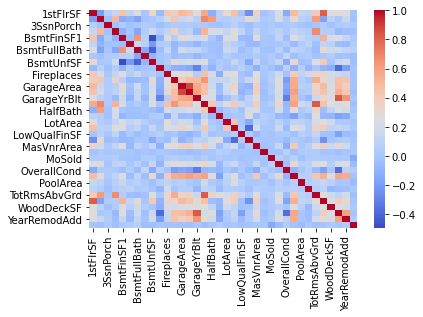

In [180]:
corr_num = X[feat_numerical].corr()
sns.heatmap(corr_num, cmap='coolwarm')

In [ ]:
# TODO(solution): Incorporate filtering into the pipeline by creating custom encoder class

❓ Use [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) combined with a heatmap...
- to whether some **ordinally encoded** features are almost entirely "ordered" similarily than others
- Then, create a "filter" in your pipeline that removes any ordinal features correlated below a certain threshold

<AxesSubplot:>

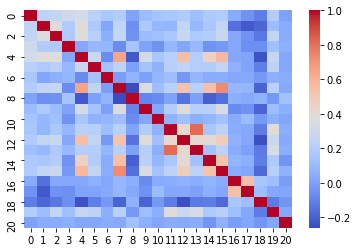

In [195]:
X_ordinally_encoded = pd.DataFrame(preproc_ordinal.fit_transform(X[feat_ordinal]))
sns.heatmap(X_ordinally_encoded.corr(method="spearman"), cmap='coolwarm')

❓ Another way to filter out feature relies solely on removing those with the lowest variance.  
- Think about it: a feature which only takes one value is useless (and has a variance of 0).  
- Try to add a `VarianceThreshold` to the end of your pipeline

Text(0, 0.5, 'Number of Feature Remaining')

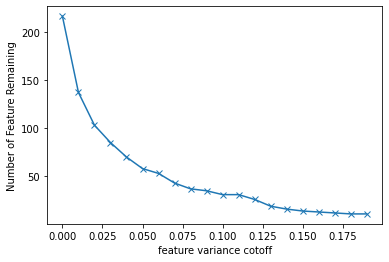

In [186]:
from sklearn.feature_selection import VarianceThreshold

def number_feature_remaining(cutoff=0):
    preproc_transformer = make_column_transformer(
        (preproc_numerical, make_column_selector(dtype_include=('int64', 'float64'))),
        (preproc_ordinal, feat_ordinal),
        (preproc_norminal, feat_norminal),
        remainder='drop')
    
    preproc_selector = VarianceThreshold(cutoff)
    
    preproc = make_pipeline(
        preproc_transformer,
        preproc_selector)
    
    return preproc.fit_transform(X).shape[1]

cutoff_values = np.arange(0, 0.2, 0.01)
plt.plot(cutoff_values, [number_feature_remaining(t) for t in cutoff_values], marker='x')
plt.xlabel("feature variance cotoff")
plt.ylabel('Number of Feature Remaining')

In [192]:
feature_droping = pd.concat([pd.Series(cutoff_values),  pd.Series([number_feature_remaining(t) for t in cutoff_values])], 
                            axis=1)
feature_droping

,0,1
0,0.00,216
1,0.01,137
2,0.02,103
3,0.03,85
4,0.04,70
5,0.05,58
6,0.06,53
7,0.07,43
8,0.08,37
9,0.09,35


In [193]:
# ☝️ We could decide to put a 0.025 threshold on the categorical features to divide their number by more than half

### Final preproc pipeline
❓ store here your final version of the preproc pipeline

In [196]:
# Define the three features (numerical, ordinal and norminal) to be passed into the column transformer

feat_numerical = sorted(X.select_dtypes(include=['int64', "float64"]).columns)
feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_norminal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

In [197]:
# Define the three pipelines then combine them in a column transformer

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy='constant', fill_value="missing"),
    OrdinalEncoder(categories=feat_ordinal_values_sorted,
                    dtype=np.int64,
                    handle_unknown='use_encoded_value',
                    unknown_value=-1),
    MinMaxScaler()
)


preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)


preproc_norminal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore')
)


preproc_transformer = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_norminal, feat_norminal),
    remainder='drop')

#  keep only 75% of all features
preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=75
)

# final preprocess pipeline
preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['1stFlrSF', '2ndFlrSF',
                                                   '3SsnPorch', 'BedroomAbvGr',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'BsmtUnfSF',
                                                   'EnclosedPorch',
                                                   'Fireplaces', 'FullBath',
                                                   'GarageArea', 'GarageCars',
                                                   'Gara...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=75,
                                  score_func=<function mutual_info_regression at 0x7f328db46f70>))])

In [198]:
# Check shape
preproc_fitted = preproc.fit(X,y)
preproc_fitted_log = preproc.fit(X,y_log)
preproc_fitted_log.transform(X).shape

(1460, 162)

In [199]:
# # TODO: treat cyclical features
# feat_cyclical = sorted([
#     "MoSold"  # Month Sold (MM)
# ])

## Models Iteration

In [238]:
# SOLUTION
allow_grid_searching = True # use True to activate girdsearch in the notebook cells below

# Cache the preprocessing step of the pipeline
from tempfile import mkdtemp
from shutil import rmtree
cachedir = mkdtemp()

### Linear Models (Lasso, Ridge, ElasticNet, SGDRegressor)

In [249]:
# Ridge with normal(y) target
r_model = Ridge()
pipe_ridge = make_pipeline(preproc, r_model, memory=cachedir)
cross_val_score(pipe_ridge, X, y, cv=5, scoring=rmsle).mean()

/home/chidi/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/chidi/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/chidi/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/chidi/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/tmp/ipykernel_5128/3954459351.py", line 6, in <lambda>
    rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_er

nan

In [250]:
# Ridge with log_target(y_log)
r_model = Ridge()
pipe_ridge = make_pipeline(preproc, r_model, memory=cachedir)
cross_val_score(pipe_ridge_2, X=X, y=y_log, cv=5, scoring=rmse).mean()

0.13757233056364457

In [246]:
# Grid search the Ridge regularization
if allow_grid_searching:
    param_grid = {'ridge__alpha': np.linspace(0.5, 2, 20)}
    search_ridge = GridSearchCV(pipe_ridge_2, param_grid=param_grid, cv=5, 
                                n_jobs=-1, scoring=rmse_neg)
    search_ridge.fit(X,y_log)
    print(search_ridge.best_params_)
    search_ridge.best_score_

{'ridge__alpha': 2.0}


### KNN

In [258]:
model = KNeighborsRegressor()
pipe_knn = make_pipeline(preproc, model)

In [260]:
scores = cross_val_score(pipe_knn, X, y_log, cv=5, scoring=rmse)
scores.mean()

0.20496479353014135

In [240]:
# Grid search KNN
if allow_grid_searching:
    param_grid = {'kneighborsregressor__n_neighbors': [3,4,5,6,7,8,9,10,15,20,30]}
    search_knn = GridSearchCV(pipe_knn, param_grid=param_grid,cv=5,
                             n_jobs=-1, scoring=rmsle_neg, verbose=2)
    search_knn.fit(X, y_log);
    print(search_knn.best_params_)
    search_knn.best_score_

Fitting 5 folds for each of 11 candidates, totalling 55 fits
{'kneighborsregressor__n_neighbors': 8}


In [279]:
pipe_knn_best = search_knn.best_estimator_

### SVM

In [253]:
model = SVR()
pipe_svm = make_pipeline(preproc, model, memory=cachedir)

In [254]:
scores = cross_val_score(pipe_svm, X, y_log, cv=5, scoring=rmse)
scores.mean()

0.12947014822864666

In [257]:
# Grid search SVM
if allow_grid_searching:
    param_grid = {'svr__C': [0.5, 0.7, 1, 2, 5, 10],
                 'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
                 'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
    search_svm = GridSearchCV(pipe_svm, param_grid=param_grid, cv=5,
                             n_jobs=-1, scoring=rmse_neg, verbose=2)
    search_svm.fit(X, y_log);
    print(search_svm.best_params_)
    search_svm.best_score_

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'svr__C': 1, 'svr__epsilon': 0.01, 'svr__kernel': 'rbf'}


### Trees

In [261]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
pipe_tree = make_pipeline(preproc, model, memory=cachedir)
score = cross_val_score(pipe_tree, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.015395099223704337


0.2084964711539147

### Random Forest

In [262]:
model = RandomForestRegressor(max_depth=50, min_samples_leaf=20)
pipe_forest = make_pipeline(preproc, model, memory=cachedir)
score = cross_val_score(pipe_forest, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.00787690257743636


0.16258768893302497

### Boosted Trees

In [263]:
model_adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))
pipe_boost = make_pipeline(preproc, model_adaboost, memory=cachedir)
score = cross_val_score(pipe_boost, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.010014902981947555


0.13994735141732234

### Stacking

In [264]:
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

model = VotingRegressor(
    estimators=[("gboost", gboost), ("adaboost", adaboost), ('ridge', ridge), ("svm_rbf", svm)],
    weights=[1,1,1,1],
    n_jobs=-1
)

pipe_ensemble = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe_ensemble, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
print(score.std())
score.mean()

0.013518166317511557


0.12002158930651805

### XGBOOST

In [265]:
from xgboost import XGBRegressor

In [266]:
# Create eval test just for early stopping purpose (XGBOOST and Deep Learning)
X_train, X_eval, y_train_log, y_eval_log = train_test_split(X, y_log, random_state=42)

In [268]:
# Istantiate model
model_xgb = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.05)

In [274]:
# Option 1: Integrate XGB into Sklearn's pipeline
# It allows to GridSearchCV its best hyperparams
pipe_xgb = make_pipeline(preproc, model_xgb)
cross_val_score(pipe_xgb, X, y_log, cv=5, scoring=rmse, n_jobs=-1).mean()

0.127994235123647

Best Validation Score 0.136401


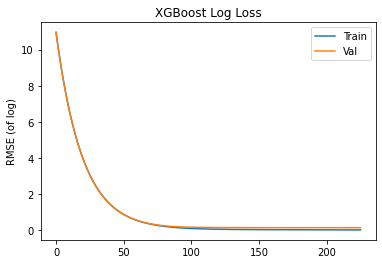

In [275]:
# Option 2: Use XGBoost Library to fit it
# It allows to use an early_stopping criteria with a Train/Val slit
X_train_preproc = preproc.fit_transform(X_train, y_train_log)
X_eval_preproc = preproc.transform(X_eval)

model_xgb.fit(X_train_preproc, y_train_log,
        verbose=False,
        eval_set=[(X_train_preproc, y_train_log), (X_eval_preproc, y_eval_log)],
        eval_metric=["rmse"],
        early_stopping_rounds=10)

# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']["rmse"])
x_axis = range(0, epochs)

# plot rmsle loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax.legend(); plt.ylabel('RMSE (of log)'); plt.title('XGBoost Log Loss')

print("Best Validation Score", min(results['validation_1']['rmse']))

# 🏅FINAL SUBMISSION

Discover the real test score by submitting on Kaggle! 

In [280]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")
X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

In [281]:
pipe_knn_best.fit(X, y_log)
predictions_log = pipe_knn_best.predict(X_test)
predictions = np.exp(predictions_log)

In [282]:
results = pd.concat([X_test_ids, pd.Series(predictions, name='SalePrice')], axis=1)
results

,Id,SalePrice
0,1461,131919.266229
1,1462,141587.562028
2,1463,183735.916397
3,1464,194402.072130
4,1465,209520.956140
...,...,...
1454,2915,84802.304872
1455,2916,92390.342570
1456,2917,118408.290591
1457,2918,127563.322092


In [283]:
# Export to Kaggle format submission and submit it online!
results.to_csv("submission_final.csv", header=True, index=False)

In [284]:
# Clear the cache directory at the end
rmtree(cachedir)

## Using Neural Networks to optimize the model

In [1]:
X_train, X_val, y_train, y_val = train_test_split(X_preproc, y, test_size=0.3, shuffle=True)

NameError: name 'train_test_split' is not defined

In [ ]:
def initialize_model(X):
    
    # Model architecture
    model = Sequential()
    model.add(layers.Dense(20, activation='relu', input_dim=X.shape[1])),
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    
    model.compile(loss='msle', # we directly optimize for the kaggle's metric!
                  optimizer='adam')
    
    return model 

In [ ]:
model = initialize_model(X_train)
model.summary()

In [ ]:
model = initialize_model(X_train)

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=500,
                    batch_size=16,
                    verbose=1)